## Ray 설치

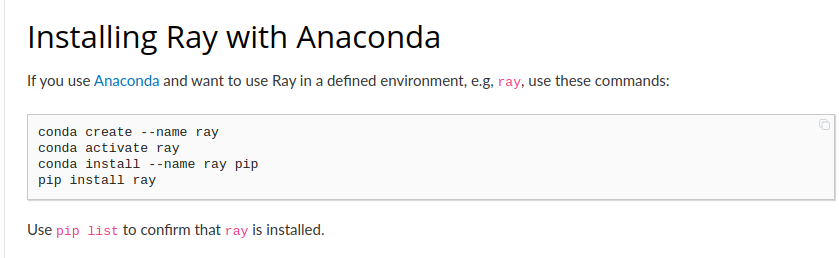

# Ray Tutorial

#### Ray는 import 뿐만 아니라, 사용하기 위해서 ray.init()이 필요하다

Reference Link

    https://data-newbie.tistory.com/415,
    https://towardsdatascience.com/modern-parallel-and-distributed-python-a-quick-tutorial-on-ray-99f8d70369b8

    기존의 python에 있는 multiprocessing은 수치 데이터 처리, 상태 저장 연산, 값비싼 초기화를 통한 연산 등 몇 가지 중요한 애플리케이션 클래스에 비해 부족하다고 한다. 그 이유는 다음의 두 가지 주된 특성에 기인한다.

    1. Inefficient handling of numerical data.
    2. Missing abstractions for stateful computation (i.e., an inability to share variables between separate “tasks”).

In [1]:
import ray
import time

ray.init()

2021-01-22 20:31:04,895	INFO services.py:1173 -- View the Ray dashboard at http://127.0.0.1:8267


{'node_ip_address': '192.168.0.61',
 'raylet_ip_address': '192.168.0.61',
 'redis_address': '192.168.0.61:44819',
 'object_store_address': '/tmp/ray/session_2021-01-22_20-31-04_348594_88662/sockets/plasma_store',
 'raylet_socket_name': '/tmp/ray/session_2021-01-22_20-31-04_348594_88662/sockets/raylet',
 'webui_url': '127.0.0.1:8267',
 'session_dir': '/tmp/ray/session_2021-01-22_20-31-04_348594_88662',
 'metrics_export_port': 50499,
 'node_id': '4b491c63aee62558ebaab15d3db6fb7d5d860047'}

#### 실행 후, localhost: [port번호] 가 보이는데, 이 주소는 resource 현황을 알려준다.

#### 일반 함수를 @ray.remote라는 decoration을 통해 다음과 같이 선언한다.

    @ray.remote
    def f(x):
        time.sleep(5)
        return x * x

이렇게 선언하고 나면, 이제 함수는 
    
    함수명.remote()

와 같이 활용할 수 있다. 여기서, remote()는 task를 하나의 thread에 던져주는 역할을 한다. 따라서 코드를 실행시켜나갈 때 remote() 가 있는 라인은, thread에 해당 task를 던지고 바로 다음 줄로 넘어간다. 따라서, 

    results = []
    for i in range(10):
        results.append(f.remote(i))

이렇게 실행하면 함수f의 결과를 기다리지 않고, 그냥 thread에 던져놓고 바로바로 반복문을 수행하므로 순식간에 10번의 loop이 끝납니다.

    ray.get(results)
    
를 다음에 실행하면, 모든 thread의 실행이 끝났을 때, 출력을 얻습니다.

In [2]:
# 병렬 처리하고 싶은 함수가 있으면, 아래의 데코레이터로 지정하면 병렬 모드로 쓸 수 있다. 

@ray.remote
def f(x):
    time.sleep(5)
    return x * x

In [3]:
# number of workers 변수를 통해서 위에서 선언한 함수를 몇 개를 동시에 실행시킬지 정하자.

number_of_workers = 10

tic = time.time()
results = [f.remote(i) for i in range(number_of_workers)]
print(ray.get(results)) 


print("총 걸린 시간: ", time.time()-tic)

[0, 1, 4, 9, 16, 25, 36, 49, 64, 81]
총 걸린 시간:  5.054338693618774


In [ ]:
number_of_workers = 40

tic = time.time()
results = [f.remote(i) for i in range(number_of_workers)]
print(ray.get(results))
print("총 걸린 시간: ", time.time()-tic)

# 원래 병렬처리가 없었다면, 40번 함수가 호출되었으므로 40*5=200 초가 걸렸겠지만, CPU가 여려개가 동시에 병렬처리를 하여 훨씬 빠르게 처리하는 것을 확인할 수 있다.

#### 또한 Ray는 특정 데이터를 공유 메모리에 저장하고 thread 간에 공유 가능하다.

In [ ]:
# ray.put 함수를 이용해서 공유하고자 하는 객체를 지정할 수 있다.
# 이렇게 지정한 객체는 여러 함수가 접근하여 필요한 처리를 할 수 있고, 따라서 메모리를 매우 효율적으로 쓸 수 있다.

import numpy as np
import psutil
import scipy.signal

@ray.remote
def f(image, random_filter):
    # Do some image processing.
    return scipy.signal.convolve2d(image, random_filter)[::5, ::5]

num_of_workers = 12
filters = [np.random.normal(size=(4, 4)) for _ in range(num_of_workers)]

tic = time.time()
for _ in range(10):
    image = np.zeros((3000, 3000))
    image_id = ray.put(image)  # 공유메모리에 올리는 선언
    results = [f.remote(image_id, filters[i]) for i in range(num_of_workers)]
    ray.get(results)
print("걸린시간(s): ", time.time() - tic)

#### 시간을 비교하기 위해서 이번에는 ray 없이 for문을 돌려보자

In [ ]:
def f(image, random_filter):
    return scipy.signal.convolve2d(image, random_filter)[::5, ::5]

num_of_workers = 4
filters = [np.random.normal(size=(4, 4)) for _ in range(num_of_workers)]

tic = time.time()
for _ in range(10):
    image = np.zeros((3000, 3000))
    results = [f(image, filters[i]) for i in range(num_of_workers)]
print("걸린시간(s): ", time.time() - tic)

#### 정확히 num_of_workes의 배수만큼 느려진 것은 아니지만 확연한 차이를 알 수 있다. 더욱이 놀라운 점은 multiprocessing과 다른게, image라는 배열을 여러 thread가 ray.put() 메소드로 쉽게 공유할 수 있다는 점이다.

In [ ]:
@ray.remote
def create_matrix(size, num):
    time.sleep(num)
    return np.random.normal(size=size)

@ray.remote
def multiply_matrices(x, y):
    return np.dot(x, y)

x_id = create_matrix.remote([1000, 1000], 6)
y_id = create_matrix.remote([1000, 1000], 2)
z_id = multiply_matrices.remote(x_id, y_id)

# 아래의 걸린 시간을 보면, x가 늦게 끝나므로 x가 종료되는 시점에 z가 계산됨을 알 수 있다. 
tic = time.time()
z = ray.get(z_id)
print("걸린시간(s): ", time.time() - tic)

#### 이번에는 다음과 같은 연산 그래프를 실현해보자.
왼쪽 그림과 오른쪽 그림의 연산 속도는 얼마나 차이가 날까?

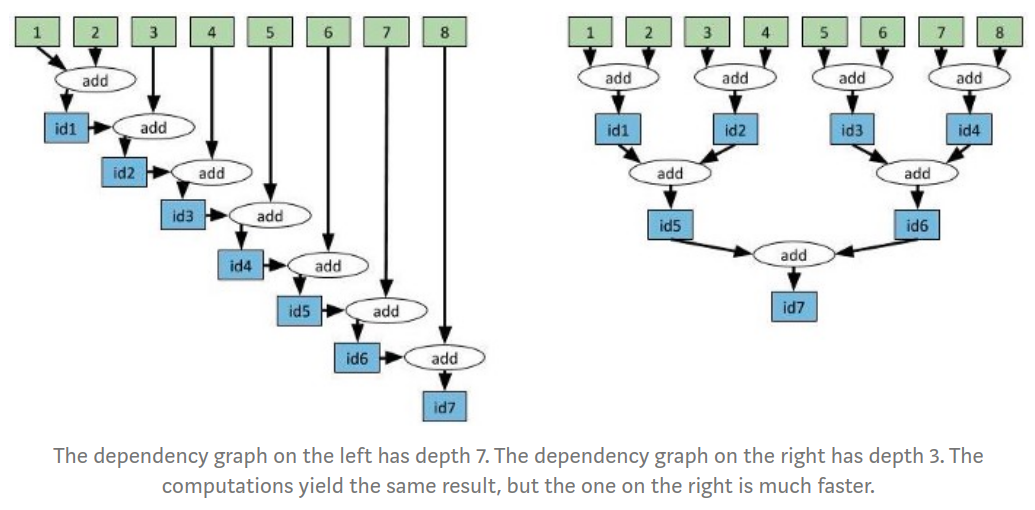

In [ ]:
# 위의 그림에 있는 연산처리 순서대로 코드를 테스트 해본 것.

@ray.remote
def add(x, y):
    time.sleep(1)
    return x + y

# Aggregate the values slowly. This approach takes O(n) where n is the
# number of values being aggregated. In this case, 7 seconds.
tic = time.time()
id1 = add.remote(1, 2)
id2 = add.remote(id1, 3)
id3 = add.remote(id2, 4)
id4 = add.remote(id3, 5)
id5 = add.remote(id4, 6)
id6 = add.remote(id5, 7)
id7 = add.remote(id6, 8)
result = ray.get(id7)
print("result", result)
print("걸린시간(s): ", time.time() - tic)

# Aggregate the values in a tree-structured pattern. This approach
# takes O(log(n)). In this case, 3 seconds.
tic = time.time()
id1 = add.remote(1, 2)
id2 = add.remote(3, 4)
id3 = add.remote(5, 6)
id4 = add.remote(7, 8)
id5 = add.remote(id1, id2)
id6 = add.remote(id3, id4)
id7 = add.remote(id5, id6)
result = ray.get(id7)
print("result", result)
print("걸린시간(s): ", time.time() - tic)

아래는 위와 동일한 연산. 좀 더 간단하게 표현한 것.

In [ ]:
# 느린 것
values = [1, 2, 3, 4, 5, 6, 7, 8]
while len(values) > 1:
    values = [add.remote(values[0], values[1])] + values[2:]
result = ray.get(values[0])

# 빠른 것. 
# 코딩 요령: 리스트를 자르고, ray.remote를 리스트의 뒤로 넘긴 것.
values = [1, 2, 3, 4, 5, 6, 7, 8]
while len(values) > 1:
    values = values[2:] + [add.remote(values[0], values[1])]
result = ray.get(values[0])

#### 이번에는 class를 ray를 이용하여 병렬로 처리해보자

In [ ]:
@ray.remote
class Counter(object):
    def __init__(self):
        self.n = 0

    def increment(self, num):
        time.sleep(5)
        self.n += (num**3)
        print(self.n)

    def read(self):
        return self.n

number_of_workers = 4

tic = time.time()
counters = [Counter.remote() for i in range(number_of_workers)]
[cnt_class.increment.remote(idx) for idx, cnt_class in enumerate(counters)]
results = [c.read.remote() for c in counters]
print(ray.get(results))
print("걸린시간(s): ", time.time() - tic)

number_of_workers = 12

tic = time.time()
counters = [Counter.remote() for i in range(number_of_workers)]
[c.increment.remote(idx) for idx, c in enumerate(counters)]
results = [c.read.remote() for c in counters]
print(ray.get(results))
print("걸린시간(s): ", time.time() - tic)


#### Multiprocessing 페키지는 어떤 output이 어느 thread에서 온 것인지 확인하려면 별도의 메소드로 확인해주어야 했지만, ray는 PID를 자체적으로 함께 출력해준다. 

In [3]:
import numpy as np

In [4]:
# 메세지를 저장하고 불러오는 class를 선언해보자

@ray.remote
class MessageActor(object):
    def __init__(self):
        self.messages = []
    
    def add_message(self, message):
        self.messages.append(message)
        
    def get_and_clear_messages(self):
        messages = self.messages
#         time.sleep()
        self.messages = []
        return messages

# worker라는 함수는 메세지를 받아서 저장해주는 역할을 한다.
@ray.remote
def worker(message_actor, j):
    for i in range(100):
        time.sleep(np.random.uniform(0.5, 1)) # random 하게 시간을 기다리게 한다.
        message_actor.add_message.remote("Message {} from worker {}.".format(i, j))
        
# 메세지 class 의 인스턴스 생성
message_actor = MessageActor.remote()

# 위에서 생성한 클레스에 3개의 병렬 task를 주었다.
# 3개의 task는 동시에 1개의 클래스 변수(여기서는 메세지를 저장하는 리스트)에
# 계속해서 서로서로 append를 하게 된다. 
num_of_workers = 10
[worker.remote(message_actor, j) for j in range(num_of_workers)]

# for문을 돌면서 계속해서 massage를 가져온다.
for _ in range(100):
    # 아래줄 처럼 실행하면 에러가 난다. @ray.remote 로 decorate이 되었으면 
    # 클래스 메소드를 실행할 때는 .remote()를 활용해야 한다. 
    # new_messages = message_actor.get_and_clear_messages()
    # 올바른 예시
    new_messages = ray.get(message_actor.get_and_clear_messages.remote())
    print("New messages:", new_messages)
    time.sleep(1)

# 위의 명령어를 실행하면 다음과 비슷한 출력이 나온다.
# New messages: []
# New messages: ['Message 0 from worker 1.', 'Message 0 from worker 0.']
# New messages: ['Message 0 from worker 2.', 'Message 1 from worker 1.', 'Message 1 from worker 0.', 'Message 1 from worker 2.']
# New messages: ['Message 2 from worker 1.', 'Message 2 from worker 0.', 'Message 2 from worker 2.']
# New messages: ['Message 3 from worker 2.', 'Message 3 from worker 1.', 'Message 3 from worker 0.']
# New messages: ['Message 4 from worker 2.', 'Message 4 from worker 0.', 'Message 4 from worker 1.']
# New messages: ['Message 5 from worker 2.', 'Message 5 from worker 0.', 'Message 5 from worker 1.']

New messages: []
New messages: ['Message 0 from worker 8.', 'Message 0 from worker 9.', 'Message 0 from worker 3.', 'Message 0 from worker 1.', 'Message 0 from worker 4.', 'Message 0 from worker 7.', 'Message 0 from worker 2.', 'Message 0 from worker 6.', 'Message 0 from worker 0.', 'Message 0 from worker 5.']
New messages: ['Message 1 from worker 7.', 'Message 1 from worker 9.', 'Message 1 from worker 8.', 'Message 1 from worker 1.', 'Message 1 from worker 2.', 'Message 1 from worker 5.', 'Message 1 from worker 3.', 'Message 1 from worker 6.', 'Message 1 from worker 0.', 'Message 1 from worker 4.', 'Message 2 from worker 9.']


KeyboardInterrupt: 

#### 이 코드에서 생각해볼 점. 

    위에서 class는 두 가지 메소드를 가진다.
    
    1) add_message와 2) get_and_clear_messages 로써 2개인데,

    worker 함수는, message_actor라는 클래스 인스턴스의 add_message 메소드를 실행하는 함수였고, 이는 계속해서 self.messege라는 클래스 변수를 변동시켰다.

    그리고 코드 아래 부분에서는 self.messege라는 변수에 새로운 메세지를 append하는 작업이 계속 되고 있는 중임에도, 
    
    클래스의 다른 메소드인 get_and_clear_messages를 실행하였다. 즉 다시말해서 다른 함수가 계속해서 새로운 '쓰기'작업을 하는 중에 이와는 또 다른 함수가 똑같은 변수에 접근할 수 있는 것.
    
    이는 바로, 강화학습의 Q-learning 기법에서 많이 쓰이는 Replay Buffer를 여러 agent가 공유하고, 쓰기와 읽기를 동시에 할 수 있음을 시사한다.

    클래스의 다른 메소드를 동시에 실행하는 것까지는 놀라운 일이 아닐지라도,
    self.messege 라는 변수를 서로 다른 함수끼리 공유하면서 지속적으로 append하고 accessing하는 것을 실시간으로 굉장히 심플한 문법으로 가능하다는 것은 큰 장점이라고 생각한다.

In [5]:
import numpy as np
from collections import defaultdict

num_of_workers = 4

@ray.remote
class StreamingPrefixCount(object):
    def __init__(self):
        self.prefix_count = defaultdict(int)
        self.popular_prefixes = set()

    def add_document(self, document):
        for word in document:
            for i in range(1, len(word)):
                prefix = word[:i]
                self.prefix_count[prefix] += 1
                if self.prefix_count[prefix] > 3:
                    self.popular_prefixes.add(prefix)

    def get_popular(self):
        return self.popular_prefixes

streaming_actors = [StreamingPrefixCount.remote() for _ in range(num_of_workers)]

tic = time.time()
for i in range(num_of_workers * 10):
    document = [np.random.bytes(20) for _ in range(30000)]
    streaming_actors[i % num_of_workers].add_document.remote(document)

results = ray.get([actor.get_popular.remote() for actor in streaming_actors])
popular_prefixes = set()
for prefixes in results:
    popular_prefixes |= prefixes
print("걸린시간(s): ", time.time() - tic)
print(popular_prefixes)

걸린시간(s):  38.695748805999756
{b'y\x00', b'\xcf\xac', b'K[', b'\xfc\xbe', b'\xeb\xb4', b'\x8b5', b'PB', b'\x98\x82', b'\xb2\x95', b's\x17', b'\x8e\x91', b'~r', b'\xc6g', b'\xe4H', b'\xb1}', b'\xb4d', b'q\xe1', b'\x9e\x83', b'\xcfI', b'+\x01', b'\xe8\x95', b'\xee\xe7', b'<p', b'\xd9\xfe', b'yd', b'\x97\xd7', b'\x16\xfc', b'\x02q', b'C\xc2', b'A\x1a', b'\xe4\xf3', b' ;', b'0\xee', b'\xf9\xc8', b'\xb7T', b'Yg', b'\xa8\t', b'{4', b'\xaf}', b'M^', b'f!', b'\xa0\xcd', b'a\xcf', b'7|', b'\xd7\xbc', b'\x00\n', b'\xce\x86', b'\xd1\xde', b'Tt', b'Xe', b'\xb4\xd8', b'N\xde', b'1y', b'\xcb$', b'\xc4\x94', b'?\x9d', b'\xbbJ', b'(\xf7', b'7\xdb', b'\xd5\xea', b'\x81\xfc', b'~\xc8', b'-\x02', b'\x97|', b'qs', b'AT', b'\x9c\x80', b'O\x94', b'\x8d(', b'\x89\xb9', b'\x0c\xfc', b'\x99\xc9', b'\xc4\xad', b'\x93J', b'\xa5\xcc', b'\xee\x04', b'[\xc4', b'\xaf6', b'\x8ce', b'X\xa2', b'\x16\xd4', b'M\xd9', b'W\xc1', b'o6', b'\xdc\x1e', b'\xeb\xef', b'\\\xd0', b'\xd5\x03', b'_\xf9', b'\x0f8', b'\xa5K', b'\xac\x8

In [ ]:
from collections import defaultdict

num_of_workers = 4

class StreamingPrefixCount(object):
    def __init__(self):
        self.prefix_count = defaultdict(int)
        self.popular_prefixes = set()

    def add_document(self, document):
        for word in document:
            for i in range(1, len(word)):
                prefix = word[:i]
                self.prefix_count[prefix] += 1
                if self.prefix_count[prefix] > 3:
                    self.popular_prefixes.add(prefix)

    def get_popular(self):
        return self.popular_prefixes

streaming_actors = [StreamingPrefixCount() for _ in range(num_of_workers)]

tic = time.time()
for i in range(num_of_workers * 10):
    document = [np.random.bytes(20) for _ in range(30000)]
    streaming_actors[i % num_of_workers].add_document(document)

results = [actor.get_popular() for actor in streaming_actors]
popular_prefixes = set()
for prefixes in results:
    popular_prefixes |= prefixes
print("걸린시간(s): ", time.time() - tic)
print(popular_prefixes)

#### 딥러닝 모델도 Ray로 병렬?!

In [ ]:
import psutil
import ray
import sys
import tensorflow as tf

num_cpus = psutil.cpu_count(logical=False)
ray.init(num_cpus=num_cpus)
filename = '/tmp/model'

@ray.remote
class Model(object):
    def __init__(self, i):
        # Pin the actor to a specific core if we are on Linux to prevent
        # contention between the different actors since TensorFlow uses
        # multiple threads.
        if sys.platform == 'linux':
            psutil.Process().cpu_affinity([i])
        # Load the model and some data.
        self.model = tf.keras.models.load_model(filename)
        mnist = tf.keras.datasets.mnist.load_data()
        self.x_test = mnist[1][0] / 255.0

    def evaluate_next_batch(self):
        # Note that we reuse the same data over and over, but in a
        # real application, the data would be different each time.
        return self.model.predict(self.x_test)

actors = [Model.remote(i) for i in range(num_cpus)]

# Parallelize the evaluation of some test data.
for j in range(10):
    results = ray.get([actor.evaluate_next_batch.remote() for actor in actors])


    모델을 로딩하는 것은 한 번만 실행하는 것으로 충분하다.
    Ray 버전은 액터의 생성자에서 모델을 한 번만 로드하여 공유한다.
    
    만약 모델을 GPU에 배치하고 싶다면, 이 초기화는 더 비싼 비용을 들 것이다.

    multiprocessing version은 모델을 다시 reload 할 필요가 있기 때문에 느리다.
    그 이유는 mapped 함수들은 stateless를 가정하기 때문이라고 한다(?)

    multiprocessing 은 다음과 같다. 
    경우에 따라서는 initializer 인수를 사용하여 multiprocessing.Pool에이를 수행할 수 있다.
    그러나 이는 각 프로세스마다 초기화가 동일하고 다른 프로세스가 다른 설정 기능을 수행할 수 없는 설정으로 제한된다. 
    또한 다른 작업이 다른 작업자를 대상으로 하는 것을 허용하지 않는다.

In [ ]:
from multiprocessing import Pool
import psutil
import sys
import tensorflow as tf

num_cpus = psutil.cpu_count(logical=False)

filename = '/tmp/model'

def evaluate_next_batch(i):
    # Pin the process to a specific core if we are on Linux to prevent
    # contention between the different processes since TensorFlow uses
    # multiple threads.
    if sys.platform == 'linux':
        psutil.Process().cpu_affinity([i])
    model = tf.keras.models.load_model(filename)
    mnist = tf.keras.datasets.mnist.load_data()
    x_test = mnist[1][0] / 255.0
    return model.predict(x_test)

pool = Pool(num_cpus)

for _ in range(10):
    pool.map(evaluate_next_batch, range(num_cpus))